## Part 4 – Prediction

## Initial

### Imports

In [40]:
import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.io as pio

import os
import json
import warnings
from datetime import date, time, datetime
from tqdm.notebook import tqdm

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.pipeline import Pipeline, make_pipeline

from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, accuracy_score
from sklearn.inspection import permutation_importance

import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

### Constants

In [41]:
#PATH_LOCAL = 'datasets/'                                           # local path to data
#PATH_REMOTE = '/kaggle/input/yap15-heart-diseases-predictions/'    # remote path to data

CR = '\n'                                                          # new line
RANDOM_STATE = RS = 66                                             # random_state
N_CV = 5                                                           # num of cross-val batches

VALID_FRAC = 0.1                          # размер валидационной выборки, выделяемой из обцчающей
N_TRIALS = 1000                           # количество попыток для Optuna
TIMEOUT = 300                             # максимальный порог времени для Optuna
SCORING = 'roc_auc'                       # основная метрика

### Functions

In [42]:
# def custom_read_csv(file_name, separator=','):
#     """
#     чтение датасета в формате CSV:
#       сначала из локального хранилища;
#       при неудаче — из удаленного хранилища Kaggle.
#     """

#     path_local = f'{PATH_LOCAL}{file_name}'
#     path_remote = f'{PATH_REMOTE}{file_name}'
    
#     if os.path.exists(path_local):
#         return pd.read_csv(path_local, sep=separator)

#     elif os.path.exists(path_remote):
#         return pd.read_csv(path_remote, sep=separator)

#     else:
#         print(f'File "{file_name}" not found at the specified path ')

In [43]:
def add_model_metrics(models, X_train, Y_train, X_valid, Y_valid, cv=N_CV, scoring_list=['f1']):
    '''
    Принимает датафрейм со списком моделей и их характеристиками.
    Добавляет в принятый датафрейм несколько метрик.
    
    :models: датафрейм с информацией об обученных моделях
    :X_train: обучающая выборка (признаки)
    :Y_train: обучающая выборка (целевая переменная)
    :X_test: тестовая выборка (признаки)
    :Y_test: тестовая выборка (целевая переменная)
    :scoring: метрики для оценки
    '''

    for scoring in scoring_list:
    
        # результаты моделей на обучающей выборке (усреднение на кроссвалидации)
        models[scoring + '_train'] = models.model.apply(
                              lambda model: cross_val_score(model, X_train, Y_train, scoring=scoring, cv=cv, n_jobs=-1).mean())

        # результаты моделей на тестовой выборке (усреднение на кроссвалидации)
        models[scoring + '_valid'] = models.model.apply(
                              lambda model: cross_val_score(model, X_valid, Y_valid, scoring=scoring, cv=cv, n_jobs=-1).mean())
    
    # ROC_AUC, коэффициент корреляции Мэтьюса, коэффициент каппа Коэна
    models['ROC_AUC'] = models.model.apply(lambda model: roc_auc_score(Y_valid, model.predict_proba(X_valid)[:,1]))
    models['matthews_coeff'] = models.model.apply(lambda model: matthews_corrcoef(Y_valid, model.predict(X_valid)))
    models['cohen_kappa'] = models.model.apply(lambda model: cohen_kappa_score(Y_valid, model.predict(X_valid)))
    
    # оптимальные гиперпараметры
    models['best_params'] = models.study.apply(lambda model: model.best_params)
    
    return models

In [44]:
def plot_Optuna(study, plot_kind='plot_slice', model_name=''):
    '''
    Дополнительная настройка оригинальных графиков Optuna.
    Например, на графике `plot_slice` изначально цвет точек зависел от номера итерации.
    Теперь они все одинакового цвета и полупрозрачные, лучше видны скопления точек.
    
    :study: обученный объект класса OptunaSearchCV
    :plot_kind: тип графика Optuna
    :model_name: название модели
    '''
    
    if plot_kind == 'plot_slice':
        fig = optuna.visualization.plot_slice(study)
        fig.update_traces(
                          marker_color='Darkgrey',
                          marker_size=3,
                          marker_opacity=0.2,
                          marker_line_width=1,
                          marker_line_color='Black',
                         )
    
    elif plot_kind == 'plot_param_importances':
        fig = optuna.visualization.plot_param_importances(study)
        
    elif plot_kind == 'plot_optimization_history':
        fig = optuna.visualization.plot_optimization_history(study)
        fig.update_traces(
                          marker_size=5,
                          marker_opacity=0.3,
                          marker_line_width=1,
                          marker_line_color='Black',
                         )

    fig.update_layout(
                      title_text=model_name,
                      title_x=0,
                      font_size=10,
                     )    
    fig.show()

In [45]:
def plot_feature_importances(chart_title, feature_names, feature_importances):
    """
    Выводит график важности признаков, использованных моделью.
    
    :chart_title: заголовок графика
    :feature_names: названия признаков
    :feature_importances: важность признаков
    """
    
    fig, ax = plt.subplots(figsize=(15,5), dpi=PLOT_DPI)

    df = pd.DataFrame({'features': feature_names,
                       'importances': feature_importances.importances_mean,
                       'std_err': feature_importances.importances_std,
                      }).sort_values('importances', ascending=False)
    
    sns.barplot(
                x=df.importances,
                y=df.features,
                xerr=df.std_err,
                color='skyblue',
               )
    
    ax.set_title(f'{chart_title}')
    ax.set_xlim(-0.02,)

### Settings

In [46]:
# text styles
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

In [47]:
# defaults for charts

# Matplotlib, Seaborn
PLOT_DPI = 150  # dpi for charts rendering 
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plt.rc(
       'axes',
       labelweight='bold',
       titlesize=14,
       titlepad=10,
      )

# Plotly Graph_Objects
pio.templates['my_theme'] = go.layout.Template(
                                               layout_autosize=True,
                                               # width=900,
                                               layout_height=200,
                                               layout_legend_orientation="h",
                                               layout_margin=dict(t=40, b=40),         # (l=0, r=0, b=0, t=0, pad=0)
                                               layout_template='seaborn',
                                              )
pio.templates.default = 'my_theme'

# colors and maps
SYMMETRIC_CMAP = LinearSegmentedColormap.from_list('', ['steelblue', 'aliceblue', 'steelblue'])

In [48]:
# Pandas defaults
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.colheader_justify = 'left'

In [49]:
# оформление Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # отключение вывода логов при работе optuna

In [50]:
# others
warnings.filterwarnings('ignore')

## Read Data

In [51]:
data_train = pd.read_csv('C:\\Users\\Admin\\Desktop\\DS studies\\Data\\Heart diseases\\PROJECT\\For work\\FE_train.csv')  # обучающая выборка после этапа EDA
data_test = pd.read_csv('C:\\Users\\Admin\\Desktop\\DS studies\\Data\\Heart diseases\\PROJECT\\For work\\FE_test.csv')    # тестовая выборка после этапа EDA

In [52]:
data_train.head()

,cardio,age,cholesterol,gluc,gender_aphi_bined_aplo_bined_TRG_mean,gender_age_bined_weight_bined_TRG_mean,gender_cholesterol_gluc_bmi_TRG_mean,gender_smoke_alco_active_TRG_mean,gender_height_TRG_mean
0,0,50,1,1,0.263,0.373,0.303,0.496,0.502
1,1,55,3,1,0.821,0.631,1.000,0.485,0.513
2,1,52,3,1,0.529,0.462,0.667,0.523,0.466
3,1,48,1,1,0.871,0.489,0.562,0.496,0.501
4,0,48,1,1,0.194,0.264,0.299,0.523,0.513


In [53]:
data_test[data_test.notna()].count()

id                                        30000
age                                       30000
cholesterol                               30000
gluc                                      30000
gender_aphi_bined_aplo_bined_TRG_mean     30000
gender_age_bined_weight_bined_TRG_mean    30000
gender_cholesterol_gluc_bmi_TRG_mean      30000
gender_smoke_alco_active_TRG_mean         30000
gender_height_TRG_mean                    30000
dtype: int64

## Данные для моделей

### Выделение признаков и целевой переменной

In [54]:
X = data_train.drop('cardio', axis=1)
Y = data_train.cardio

X.shape, Y.shape

((68753, 8), (68753,))

### Разделение на обучающую и валидационную выборки

Валидационная выборка – часть, отрезанная от train. Нужна для локальной проверки модели.

In [55]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=VALID_FRAC, stratify=Y, random_state=RS)

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((61877, 8), (61877,), (6876, 8), (6876,))

## Модель

### Preprocessing

#### Селекторы числовых и категориальных признаков

In [56]:
selector_num = make_column_selector(dtype_include=np.number)
selector_cat = make_column_selector(dtype_exclude=np.number)

#### Предбработка числовых признаков

In [57]:
num_preprocessor = make_pipeline(
                                 StandardScaler(),
#                                IterativeImputer(initial_strategy='mean', random_state=RS),  # в данных нет пропусков
                                )

#### Предбработка категориальных признаков

Раздельно для линейных моделей и моделей на базе деревьев.

In [58]:
# for linear models
cat_preprocessor_linr = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

# for tree models
cat_preprocessor_tree = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)

#### Объединение предобработки

In [59]:
# for linear models
preprocessing_linr = make_column_transformer(
                                             (num_preprocessor, selector_num),
                                             (cat_preprocessor_linr, selector_cat),
                                             remainder='passthrough'
                                            )
# for tree models
preprocessing_tree = make_column_transformer(
                                             (num_preprocessor, selector_num),
                                             (cat_preprocessor_tree, selector_cat),
                                             remainder='passthrough'
                                            )

#### Pipelines

In [60]:
pipelines_list = [
                  Pipeline([('PT', preprocessing_tree),
                            ('XGBC', XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=RS))
                           ])
                 ]

names_list = ['XGBClassifier']
short_names_list = ['XGBC']

models = pd.DataFrame(
                      data={'name': names_list,
                            'short_name': short_names_list,
                            'model': pipelines_list,
                           },
                     )
models

,name,short_name,model
0,XGBClassifier,XGBC,"(ColumnTransformer(remainder='passthrough',\n transformers=[('pipeline',\n ..."


### Подбор гиперпараметров

#### Objective functions для Optuna

In [61]:
def objective_XGBC(trial):

    params = {
              'XGBC__max_depth': trial.suggest_int('XGBC__max_depth', 1, 20),
              'XGBC__n_estimators': trial.suggest_int('XGBC__n_estimators', 10, 200, log=True),
              'XGBC__subsample': trial.suggest_float('XGBC__subsample', 0.3, 1.0),
#               'XGBC__colsample_bytree': trial.suggest_float('XGBC__colsample_bytree', 0.3, 1.0),
              'XGBC__scale_pos_weight': trial.suggest_float('XGBC__scale_pos_weight', 0.4, 0.6),
              'XGBC__learning_rate': trial.suggest_float('XGBC__learning_rate', 0.01, 0.99),
              'XGBC__gamma': trial.suggest_float('XGBC__gamma', 0.1, 10, log=True),
              'XGBC__min_child_weight': trial.suggest_float('XGBC__min_child_weight', 0.1, 10, log=True),
              'XGBC__lambda': trial.suggest_float('XGBC__lambda', 0.1, 10, log=True),
#               'XGBC__max_leaves': trial.suggest_int('XGBC__max_leaves', 2, 200, log=True),
#               'XGBC__max_bin': trial.suggest_int('XGBC__max_bin', 10, 1000, log=True),
             }
    model.set_params(**params)
    cv_SKF = StratifiedKFold(n_splits=N_CV)
    
    return cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_SKF, n_jobs=-1).mean()

#### Вызов Optuna

In [62]:
for item in range(models.shape[0]):
    
    model = models.loc[item,'model']
    
    # создание объекта optuna.study
    study = optuna.create_study(
                                study_name=models.loc[item,'name'],
                                direction="maximize",
                                sampler=optuna.samplers.TPESampler(seed=RS)
                               )

    # оптимизация (подбор гиперпараметров)
    if models.loc[item,'short_name'] == 'XGBC':
        study.optimize(objective_XGBC, n_trials=N_TRIALS, timeout=TIMEOUT, show_progress_bar=True, n_jobs=-1)

    # извлечение и обучение лучшей модели (здесь можно сделать обучение на полном наборе данных X, Y)
    model.set_params(**study.best_params).fit(X_train, Y_train)

    # сохранение результатов в таблице моделей
    models.loc[item,'model'] = model
    models.loc[item,'study'] = study
    
    print(f'{CR}{f.BOLD}{study.study_name}{f.END}{CR}')
    print(f'Количество попыток: {len(study.trials)}')
    print(f'Лучший результат: {f.BOLD}{study.best_value:0.4f}{f.END}{CR}')
    print('Комбинация гиперпараметров:')
    print(json.dumps(study.best_params, indent=1, sort_keys=True), f'{CR}')

  0%|          | 0/1000 [00:00<?, ?it/s]


XGBClassifier

Количество попыток: 179
Лучший результат: 0.8757

Комбинация гиперпараметров:
{
 "XGBC__gamma": 8.743417721091333,
 "XGBC__lambda": 0.2684956565838877,
 "XGBC__learning_rate": 0.15943136127528545,
 "XGBC__max_depth": 14,
 "XGBC__min_child_weight": 0.780312977508543,
 "XGBC__n_estimators": 38,
 "XGBC__scale_pos_weight": 0.5208166272698982,
 "XGBC__subsample": 0.9101978401379107
} 



### Визуализация результатов подбора гиперпараметров

Помогает cкорректировать процесс подбора.

In [63]:
for item in range(models.shape[0]):
    plot_Optuna(models.loc[item,'study'], 'plot_slice', models.loc[item, 'name'])
#     plot_Optuna(models.loc[item,'study'], 'plot_param_importances', models.loc[item, 'name'])     # может работать долго !
#     plot_Optuna(models.loc[item,'study'], 'plot_optimization_history', models.loc[item, 'name'])

## Results

### Выбор лучшей модели

XGBClassifier

In [64]:
# выбор модели из таблицы

BEST_MODEL_NAME = 'XGBClassifier'
model = models.model.values[models.name == BEST_MODEL_NAME][0]

### Важность признаков

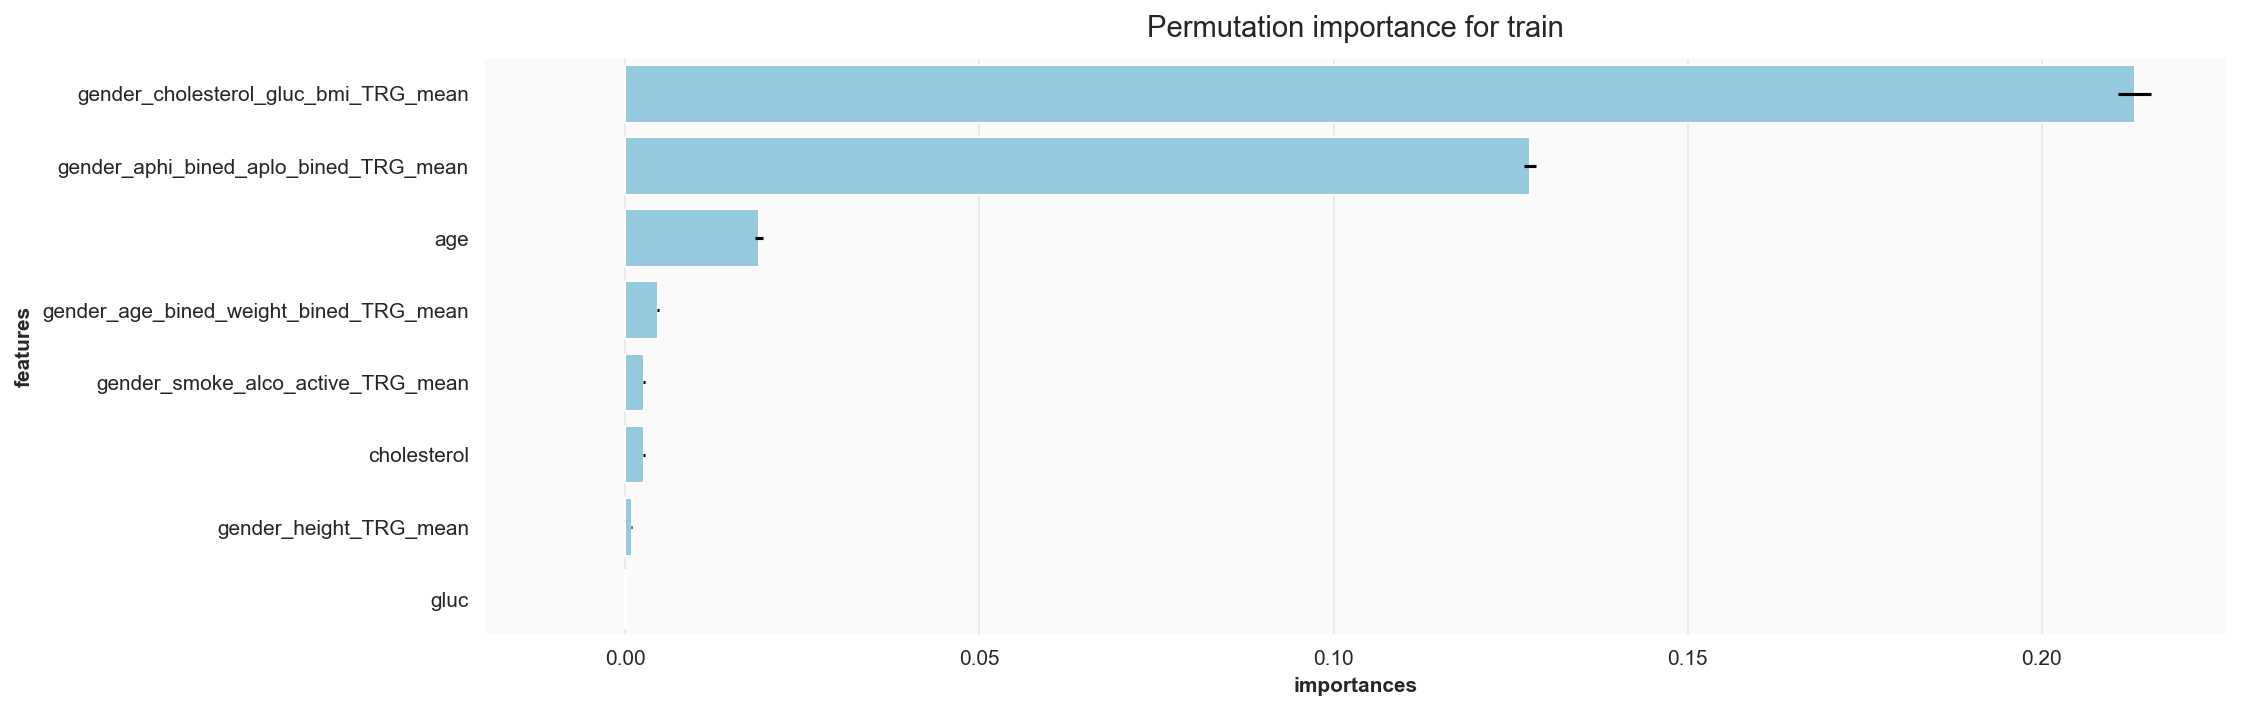

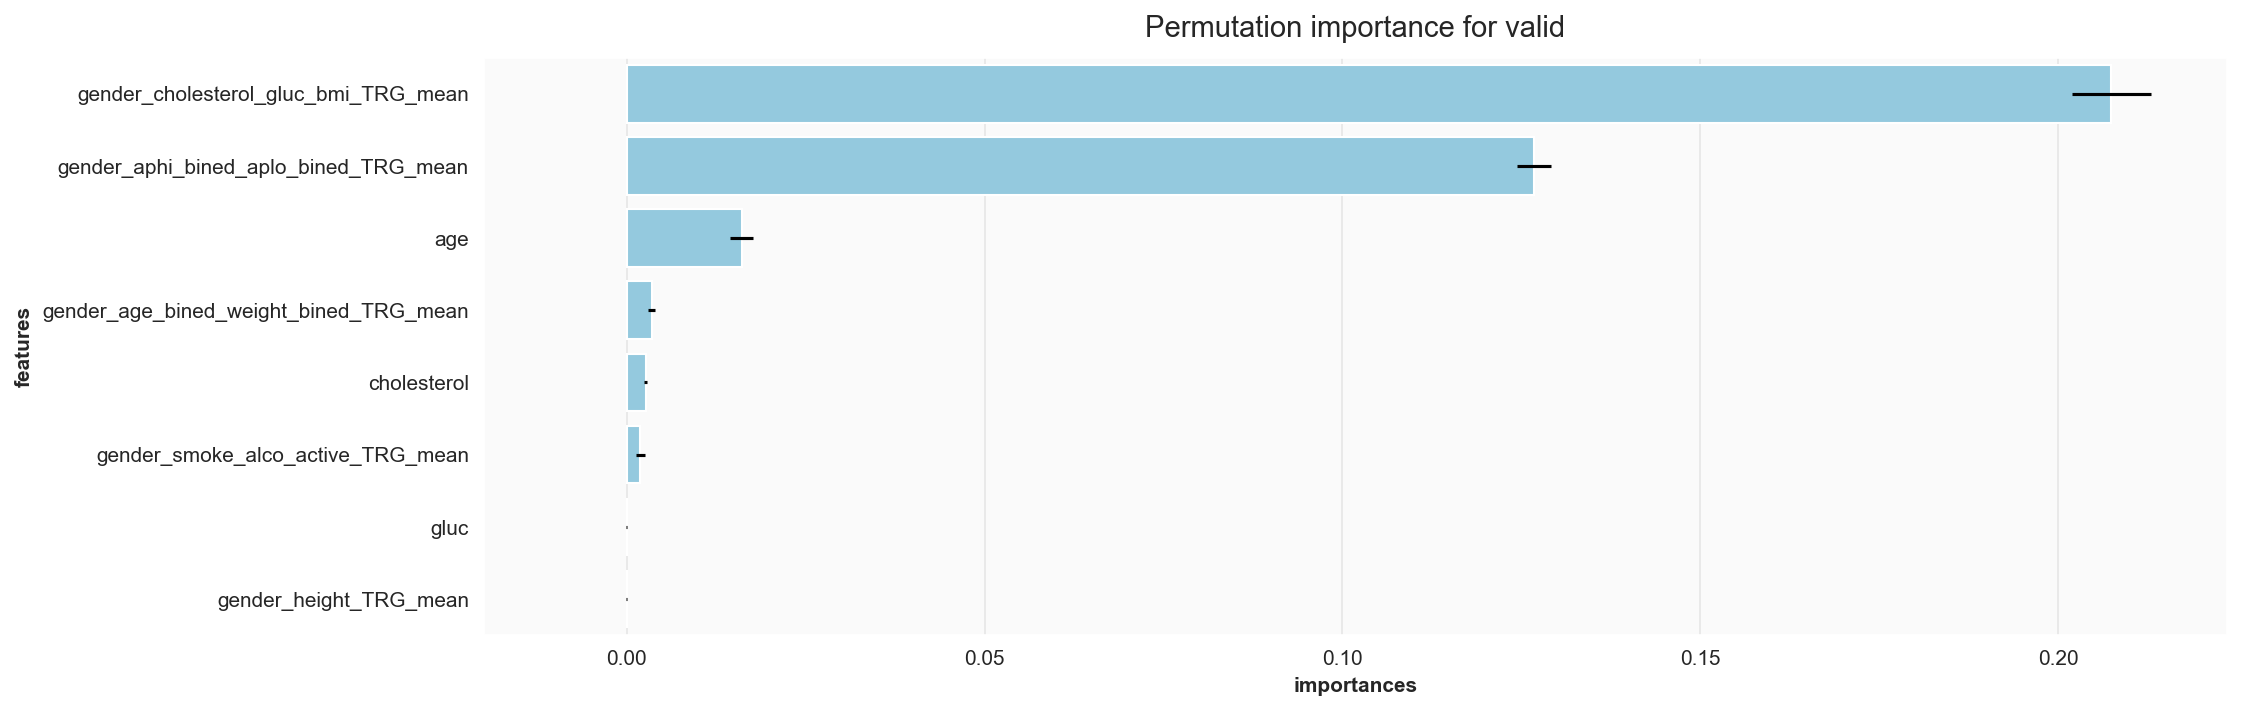

In [65]:
# permutation importance for train
plot_feature_importances(
                         'Permutation importance for train',
                         # извлечение списка признаков
                         model.feature_names_in_,
                         # вычисление важности признаков
                         permutation_importance(model,
                                                X_train, Y_train,
                                                scoring=SCORING, n_repeats=5, n_jobs=-1, random_state=RS)
                        )

# permutation importance for valid
plot_feature_importances(
                         'Permutation importance for valid',
                         # извлечение списка признаков
                         model.feature_names_in_,
                         # вычисление важности признаков
                         permutation_importance(model,
                                                X_valid, Y_valid,
                                                scoring=SCORING, n_repeats=5, n_jobs=-1, random_state=RS)
                        )

### Additional metrics

In [66]:
# дополнительные метрики моделей
models = add_model_metrics(models, X_train, Y_train, X_valid, Y_valid, cv=5, scoring_list=['roc_auc','f1','accuracy'])

models.drop(['short_name','model','study','best_params'], axis=1)

,name,roc_auc_train,roc_auc_valid,f1_train,f1_valid,accuracy_train,accuracy_valid,ROC_AUC,matthews_coeff,cohen_kappa
0,XGBClassifier,0.876,0.869,0.730,0.725,0.773,0.767,0.874,0.567,0.545


### Save models parameters and metrics

In [67]:
# # запись в файл
# models.to_excel('C:\\Users\\Admin\\Desktop\\DS studies\\Data\\Heart diseases\\PROJECT\\For work\\models{datetime.now().strftime("date_%Y-%m-%d time_%H-%M")}score_{study.best_value:0.4f}.xlsx',sheet_name='best params', index=False)

In [68]:
models.to_excel('C:\\Users\\Admin\\Desktop\\DS studies\\Data\\Heart diseases\\PROJECT\\FINAL\\models.xlsx')

In [69]:
models.to_csv('C:\\Users\\Admin\\Desktop\\DS studies\\Data\\Heart diseases\\PROJECT\\FINAL\\models.csv')

In [70]:
joblib.dump(models, 'model_dump.mdl', compress=0, protocol=None, cache_size=None)

['model_dump.mdl']

## Подготовка прогноза для участия в соревновании

In [71]:
data_pred = data_test[['id']].copy()

In [72]:
# обучение модели на полном наборе данных и прогноз модели (вероятность)
data_pred['cardio'] = model.fit(X,Y).predict_proba(data_test)[:,1]

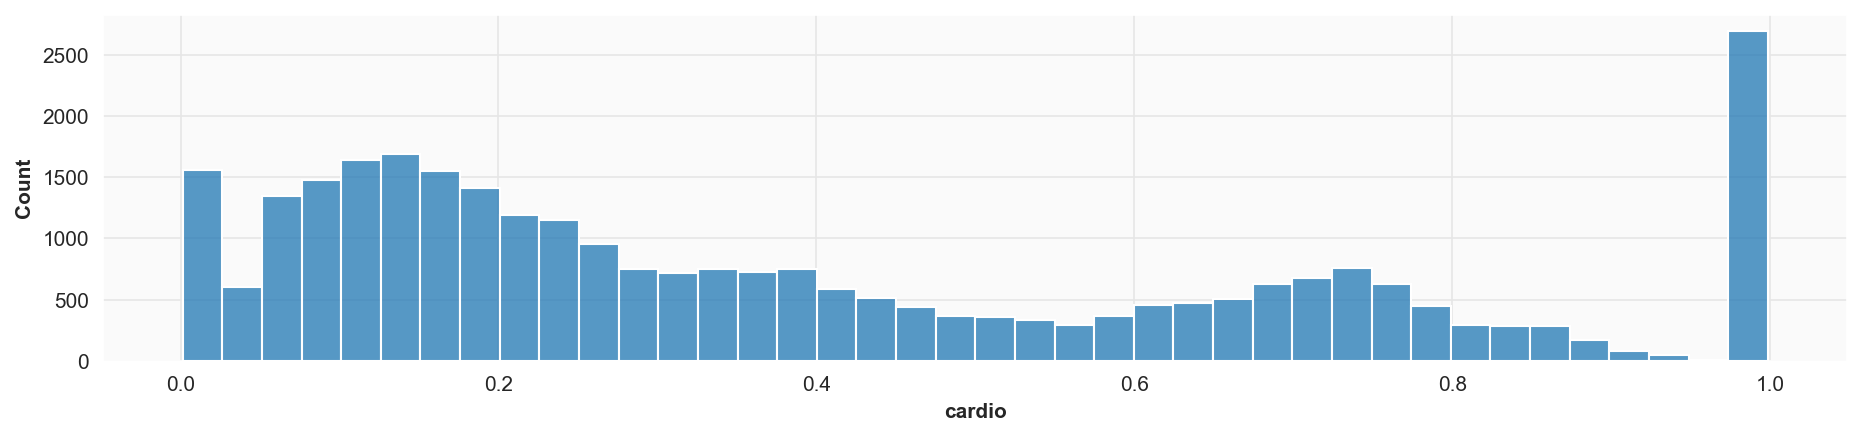

In [73]:
fig, ax = plt.subplots(figsize=(15,3), dpi=PLOT_DPI)
sns.histplot(x=data_pred.cardio, bins=40);

In [74]:
pd.qcut(data_pred.cardio, q=2).value_counts()

(0.0003699999999999999, 0.289]    15000
(0.289, 0.999]                    15000
Name: cardio, dtype: int64

In [75]:
# запись в файл
data_pred[['id','cardio']].to_csv(
    'C:\\Users\\Admin\\Desktop\\DS studies\\Data\\Heart diseases\\PROJECT\\FINAL\\Result.csv',
                      index=False,
)

In [76]:
data_pred

,id,cardio
0,5,0.316
1,6,0.358
2,7,0.277
3,10,0.001
4,11,0.115
...,...,...
29995,99984,0.897
29996,99987,0.075
29997,99989,0.284
29998,99994,0.303
